<a href="https://colab.research.google.com/github/Matteo-Candi/Fine-Tuning-with-LoRA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


In [2]:
from transformers import set_seed, BertTokenizer, TFBertModel, TFBertForSequenceClassification, TFBertMainLayer
from datasets import load_dataset, concatenate_datasets
import tensorflow as tf

from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import math

In [3]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

# Dataset and Preprocessing

In [4]:
dataset = load_dataset("go_emotions", "simplified").shuffle(seed=17)
labels = dataset['train'].features['labels'].feature.names
dataset = dataset.remove_columns('id')


def filter_labels(example):
    return len(example['labels']) < 2

for split in dataset.keys():
    dataset[split] = dataset[split].filter(filter_labels)

model_name = "bert-base-cased"
num_labels = 28

tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
def get_df_summary(df):
    label_column = df['labels'].to_list()
    flatten_col = list(itertools.chain(*label_column))
    freq_dict = dict(Counter(flatten_col))
    freq_list = list(dict(sorted(freq_dict.items())).values())
    rel_freq_list = [el / sum(freq_list) * 100 for el in freq_list]

    return rel_freq_list

In [6]:
df_train = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_test = dataset['test'].to_pandas()

# Get dataframes info.
train_freq = get_df_summary(df_train)
val_freq = get_df_summary(df_val)
test_freq = get_df_summary(df_test)

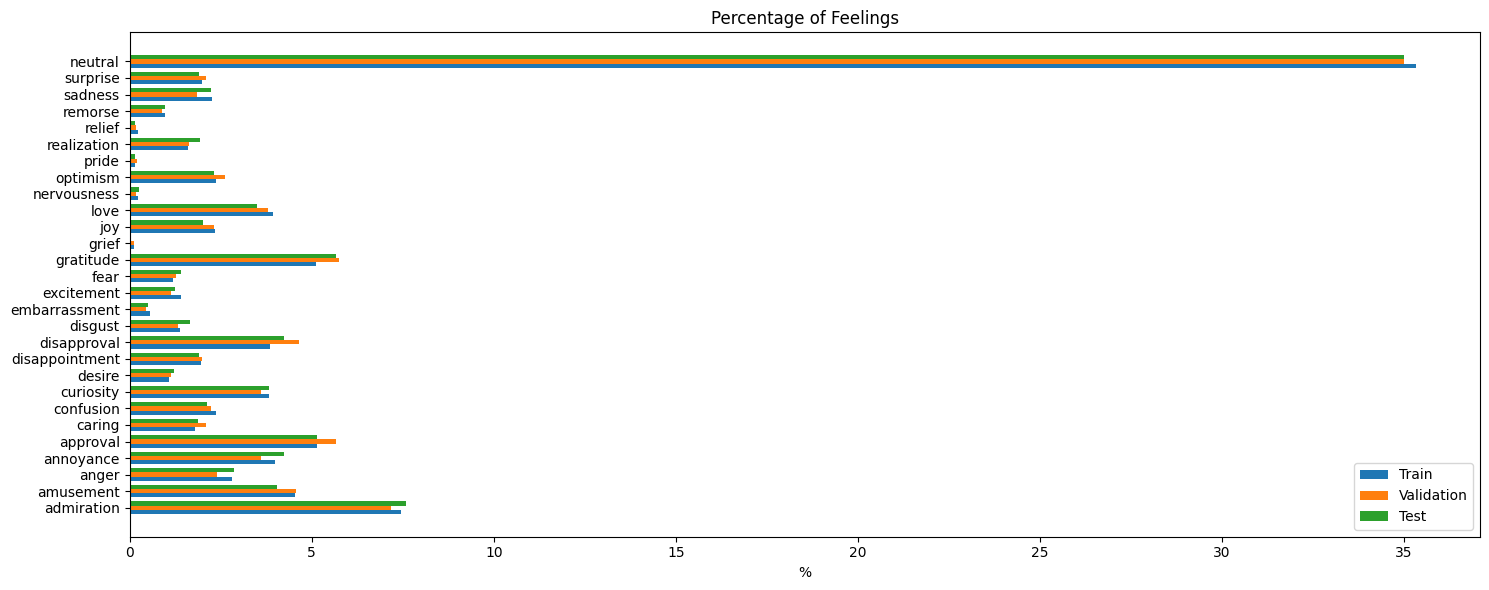

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.25
index = np.arange(len(train_freq))
bars_train = ax.barh(index, train_freq, bar_width, label='Train')
bars_val = ax.barh(index + bar_width, val_freq, bar_width, label='Validation')
bars_test = ax.barh(index + 2*bar_width, test_freq, bar_width, label='Test')
plt.xlabel('%')
plt.title('Percentage of Feelings')
plt.yticks(index + bar_width, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def tokenizer_func(text):
    '''
    Tokenizing the text using the BERT tokenizer.
    '''
    # Checking there is just one tokenization up to 316 and the second longest one is 120.
    # token_lengths = [sum(tokenized_train[i][0] != 0) for i in range(len(tokenized_train))]
    return tokenizer(text, padding = 'max_length', max_length = 120, return_tensors = "tf", truncation=True)

def one_hot_func(indices):
    '''
    Converting a value in one hot encode vector.
    '''
    one_hot_encoding = np.zeros(28, dtype=int)
    one_hot_encoding[indices] = 1
    return {'labels': one_hot_encoding}

def process_dataset_func(dataset):
    '''
    Processing the dataset to make it readable from the model.
    '''
    processed_dataset = dataset.map(lambda x: tokenizer_func(x['text']))
    processed_dataset = processed_dataset.map(lambda x: one_hot_func(x['labels']))
    processed_dataset = processed_dataset.remove_columns('text')
    return processed_dataset

In [9]:
dataset = process_dataset_func(dataset)

Map:   0%|          | 0/36308 [00:00<?, ? examples/s]

Map:   0%|          | 0/4548 [00:00<?, ? examples/s]

Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

Map:   0%|          | 0/36308 [00:00<?, ? examples/s]

Map:   0%|          | 0/4548 [00:00<?, ? examples/s]

Map:   0%|          | 0/4590 [00:00<?, ? examples/s]

In [10]:
batch_size = 32
tf_dataset_train = tf.data.Dataset.from_tensor_slices((dataset['train']['input_ids'], dataset['train']['labels'])).batch(batch_size)
tf_dataset_validation = tf.data.Dataset.from_tensor_slices((dataset['validation']['input_ids'], dataset['validation']['labels'])).batch(batch_size)
tf_dataset_test = tf.data.Dataset.from_tensor_slices((dataset['test']['input_ids'], dataset['test']['labels'])).batch(batch_size)

# Reshape labels to match the model output.
tf_dataset_train = tf_dataset_train.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_validation = tf_dataset_validation.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))
tf_dataset_test = tf_dataset_test.map(lambda input_ids, labels: (tf.squeeze(input_ids, axis=1), labels))

# Models

## Base model

In [ ]:
pretrained_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
pretrained_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_242 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 108331804 (413.25 MB)
Trainable params: 108331804 (413.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class BaseModel(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(BaseModel, self).__init__()
        self.num_labels = num_labels

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = self.num_labels)
        self.softmax = tf.keras.layers.Activation('softmax')


    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)[0]
        model_output = self.softmax(logits)


        return model_output

In [ ]:
stop

In [ ]:
base_model = BaseModel(model_name, num_labels)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

base_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

num_epochs = 5

base_model_history = base_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
1135/1135 [==============================] - 978s 806ms/step - loss: 1.6934 - accuracy: 0.5419 - val_loss: 1.3562 - val_accuracy: 0.6102
Epoch 2/5
1135/1135 [==============================] - 913s 804ms/step - loss: 1.0871 - accuracy: 0.6727 - val_loss: 1.3531 - val_accuracy: 0.6025
Epoch 3/5
1135/1135 [==============================] - 914s 805ms/step - loss: 0.6283 - accuracy: 0.8094 - val_loss: 1.6252 - val_accuracy: 0.5772
Epoch 4/5
1135/1135 [==============================] - 895s 789ms/step - loss: 0.3395 - accuracy: 0.8971 - val_loss: 1.8789 - val_accuracy: 0.5851
Epoch 5/5
1135/1135 [==============================] - 892s 786ms/step - loss: 0.1989 - accuracy: 0.9394 - val_loss: 2.1411 - val_accuracy: 0.5772


In [ ]:
base_model_history.history

# {'loss': [1.6934291124343872,
#   1.0871013402938843,
#   0.6282956004142761,
#   0.3395499289035797,
#   0.19886009395122528],
#  'accuracy': [0.5418640375137329,
#   0.6727442741394043,
#   0.809380829334259,
#   0.8971301317214966,
#   0.939434826374054],
#  'val_loss': [1.3562015295028687,
#   1.3530546426773071,
#   1.6251964569091797,
#   1.878911018371582,
#   2.1410646438598633],
#  'val_accuracy': [0.6101583242416382,
#   0.602462649345398,
#   0.5771768093109131,
#   0.5850923657417297,
#   0.5771768093109131]}

{'loss': [1.6934291124343872,
  1.0871013402938843,
  0.6282956004142761,
  0.3395499289035797,
  0.19886009395122528],
 'accuracy': [0.5418640375137329,
  0.6727442741394043,
  0.809380829334259,
  0.8971301317214966,
  0.939434826374054],
 'val_loss': [1.3562015295028687,
  1.3530546426773071,
  1.6251964569091797,
  1.878911018371582,
  2.1410646438598633],
 'val_accuracy': [0.6101583242416382,
  0.602462649345398,
  0.5771768093109131,
  0.5850923657417297,
  0.5771768093109131]}

In [ ]:
output = base_model.evaluate(tf_dataset_test)
accuracy_on_test_set = output[1]
round(accuracy_on_test_set, 4)

0.5863

## Model fine-tuned with LoRA

In [243]:
class LoraLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=False, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = 1
        self._hidden_dim = self._num_heads * original_layer_config['units']

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = tf.keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=True,
            name="lora_A",
        )

        self.B = tf.keras.layers.EinsumDense(
            equation='abc,cd->abd',
            output_shape=(120, 768),
            kernel_initializer="zeros",
            trainable=True,
            name="lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
        lora_output = self.B(self.A(inputs)) * self._scale

        return original_output + lora_output



class LoraModel(tf.keras.Model):
    def __init__(self, model):
        super(LoraModel, self).__init__()
        self.num_labels = num_labels

        # When importing the model some weigths have different initialization states.
        set_seed(17)
        self.model = model
        self.softmax = tf.keras.layers.Activation('softmax')


    def call(self, input):

        # The model detect automatically 'input_ids' and 'attention_mask'.
        logits = self.model(input)[0]
        model_output = self.softmax(logits)

        return model_output

In [235]:
def add_lora_layers_to_bert(model, rank=8, alpha=32):
    for i in range(12):
        model.bert.encoder.layer[i].attention.self_attention.value = LoraLayer(
                model.bert.encoder.layer[i].attention.self_attention.value,
                rank=rank,
                alpha=alpha)

        model.bert.encoder.layer[i].attention.self_attention.query = LoraLayer(
            model.bert.encoder.layer[i].attention.self_attention.query,
            rank=rank,
            alpha=alpha)

        model.bert.encoder.layer[i].attention.self_attention.key = LoraLayer(
            model.bert.encoder.layer[i].attention.self_attention.key,
            rank=rank,
            alpha=alpha)


def get_total_params(model):
    total_params = 0
    for variable in model.variables:
        total_params += tf.size(variable)
    return total_params.numpy()


def custom_summary(model):
    trainable_params = 0
    total_params = get_total_params(model)

    for layer in model._flatten_layers():
        if layer.name in ['self']:
            for sublayer in layer.submodules:
                trainable_variables = sublayer.trainable_variables
                for var in trainable_variables:
                    trainable_params += var.shape.num_elements()
        else:
            trainable_variables = layer.trainable_variables
            for var in trainable_variables:
                    trainable_params += var.shape.num_elements()

    print("Model: 'LoRA model'")
    print("=" * 70)
    print("Total params:", total_params)
    print("Trainable params:", trainable_params)
    print("Non-trainable params:" ,total_params - trainable_params)
    print("=" * 70)

In [236]:
pretrained_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [237]:
# Freezing all the BERT layers except for the classifier at the end.
for layer in pretrained_model._flatten_layers():
    layer.trainable = False

pretrained_model.classifier.trainable = True

# Add LoRA layers to all the qeury, key and value matrices.
add_lora_layers_to_bert(pretrained_model)

# Run the model with one sample to build the weights of the layers.
first_element = next(iter(tf_dataset_train))[0]
build_sample = pretrained_model(first_element)

Let's start considering that we want to implement LoRA layers in all the matrices if the self attention (#3) for all the heads of bert-base (#12).

The total number of Query, Key and Value matrices' parameters is $21261312$,

$21261312 / 12 = 1771776$ parameters for each head,

$1771776 / 3 = 590592 = 768 \times 768 + 768$ parameters for each matrix.


The total number of new parameters add with LoRA are $(768 \times rank + rank \times 768) \times 3 \times 12 = 442368$.

So, considering also the classifier's parameters, the total amount of trainable parameters is $442368 + 21532 = 463900$.

In [240]:
lora_model = LoraModel(pretrained_model)
custom_summary(lora_model)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

lora_model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

num_epochs = 5

lora_model_history = lora_model.fit(tf_dataset_train, validation_data=tf_dataset_validation, epochs=num_epochs, batch_size=batch_size)

In [ ]:
lora_model_history.history

Sources:
- [Multi class with Bert](https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb)

- [Dataset Preprocessing](https://huggingface.co/docs/datasets/v1.12.1/use_dataset.html)

- [Bert model layers comprehension](https://github.com/huggingface/transformers/blob/ef609958586a24b7943ad6c31184ff5a84b6f8e2/src/transformers/models/bert/modeling_tf_bert.py#L369)

- [LoRA Layer and injection](https://github.com/keras-team/keras-io/blob/master/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora.py)